## Online FDR

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [2]:
df = pd.read_csv("singh2002.csv")

In [3]:
print(f'\t\n ** dataframe shape : {df.shape} ** \n')
display(df.head())

	
 ** dataframe shape : (102, 6035) ** 



,Unnamed: 0,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,...,x.6025,x.6026,x.6027,x.6028,x.6029,x.6030,x.6031,x.6032,x.6033,y
0,1,-0.930895,-0.839996,0.062508,-0.361594,-1.124427,-1.180492,-1.092276,-1.149624,-1.157503,...,0.492456,-0.753197,0.377710,-0.845797,0.686091,-1.091779,0.347228,-0.901310,-0.252259,healthy
1,2,-0.751885,-0.848271,0.102895,2.421034,0.182211,0.639267,-0.224728,0.119039,1.694874,...,-0.959873,1.374652,-0.903991,1.332845,-0.574808,2.143548,0.101821,1.326812,-0.091503,healthy
2,3,-0.545781,-0.851687,-0.003043,-0.122089,0.837907,-1.195882,-0.931749,-1.164679,-0.549045,...,-0.869585,-0.362556,-0.907472,-0.341481,-0.577905,-0.006464,-0.920312,-0.085084,-0.704808,healthy
3,4,-1.078519,-0.159610,0.215347,-0.096277,1.050548,0.654914,1.086128,-1.127224,0.603476,...,-0.928211,-0.909437,-0.872889,-0.823525,-1.055268,-1.069403,-0.792237,-0.879015,-0.672488,healthy
4,5,-0.994677,-0.751905,-1.163109,-1.130144,1.695673,0.878677,-1.097698,1.490272,1.314783,...,0.407184,-0.935771,-0.898889,-0.849075,-1.082933,-1.097196,-0.911702,-0.905071,-0.696659,healthy


In [4]:
dfCancer = df[df["y"]=="cancer"]
dfSain = df[df["y"]=="healthy"]

In [5]:
dataCancer = dfCancer.iloc[:,[i for i in range(1,dfCancer.shape[1]-1)]].values
dataSain = dfSain.iloc[:,[i for i in range(1,dfSain.shape[1]-1)]].values

In [6]:
n0 = dataSain.shape[0]
n1 = dataCancer.shape[0]
X0_bar = dataSain.mean(axis=0)
X1_bar = dataCancer.mean(axis=0)
sigma = np.sqrt(1/n0 + 1/n1)

Z = X1_bar - X0_bar

In [61]:
pvals = 2*(1 - stats.norm.cdf(np.abs(Z)/sigma))
#mix = np.random.permutation(6033)
#pvals = pvals_original[mix]

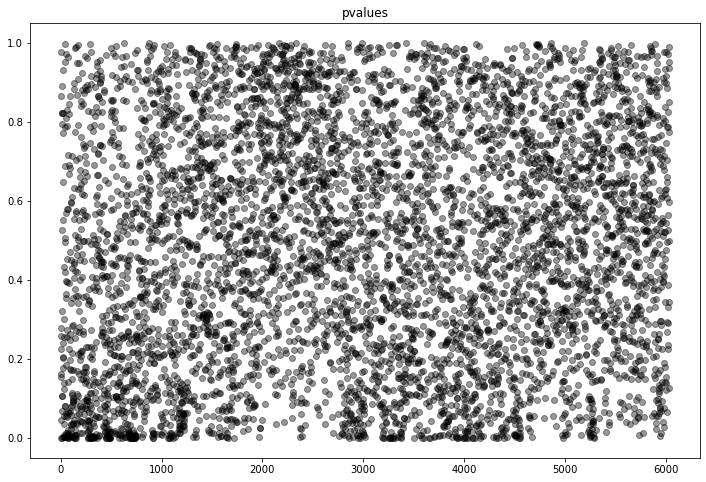

In [62]:
plt.figure(figsize = (12,8))
plt.scatter(np.arange(dataSain.shape[1]), pvals, color='k', alpha=0.4)
plt.title('pvalues');

### PROCEDURE LORD SEQUENTIELLE

In [63]:
def gamma(q, t):
    C = np.sum(np.array([1/(i+1)**q for i in range(6033)]))
    
    return((1/(C*(t+1)**q)))

#PARAMETRES LORD: 
# alpha : "initial wealth"
# pvals : "a list or array of pvalues"
# W     : initialisation 
# gamma : fonction that defines the redistribution sequence
# q     : usefull for the specific gamma we use here
# seq_alpha : either an empty list (if START) or the list of the current sequence
# R : either an empty list (if START) or the list of the past rejections/discoveries
def LORD_SEQ(alpha, pvals, W, gamma, q, seq_alpha, R):
    S = len(pvals)
    M = len(seq_alpha)
    if M==0:
        seq_alpha.append(W*gamma(q, 0))
    if len(R)>=1:
        t1 = R[0]
    #clock = 0
    for t in np.arange(S-1):
        if pvals[t] <= seq_alpha[t+M]:
            #clock += 1
            R.append(t)    
        if len(R) == 0:
            seq_alpha.append(W*gamma(q,t+1+M))
        if len(R) == 1:
            t1 = t # tau1 memorized
            seq_alpha.append(W*gamma(q,t+1+M)+(alpha-W)*gamma(q,t+1-t1+M))
        if len(R) > 1: 
            seq_alpha.append(W*gamma(q,t+1+M)-W*gamma(q,t+1-t1+M)+np.sum(alpha*gamma(q,M+t+1-np.array(R))))          
    return(R, seq_alpha)  

In [64]:
def performances_LORD(alpha, Procedure, R):
    N_Detections = len(R)
    Depenses = np.sum(Procedure)
    Budget = alpha*max(1,N_Detections)
    Bilan = Budget-Depenses
    print("Tests Multiples en ligne - Contrôle du mFDR - Procédure LORD")
    print(f"Niveau du mFDR : {alpha:.2}")
    print(f"Nombre de détections : {N_Detections}")
    print(f"Budget non dépensé : {Bilan:.3f}")
    return(N_Detections, Budget, Depenses, Bilan)  

In [65]:
alpha = 0.1
#W = alpha/2
W = alpha/2
q=1.2
#seq_gamma = gamma(q, len(pvals))
R_lordseq, Alpha_lordseq = LORD_SEQ(alpha, pvals, W, gamma, 1, [], [])

In [66]:
performances_LORD(alpha, Alpha_lordseq, R_lordseq);

Tests Multiples en ligne - Contrôle du mFDR - Procédure LORD
Niveau du mFDR : 0.1
Nombre de détections : 80
Budget non dépensé : 1.130


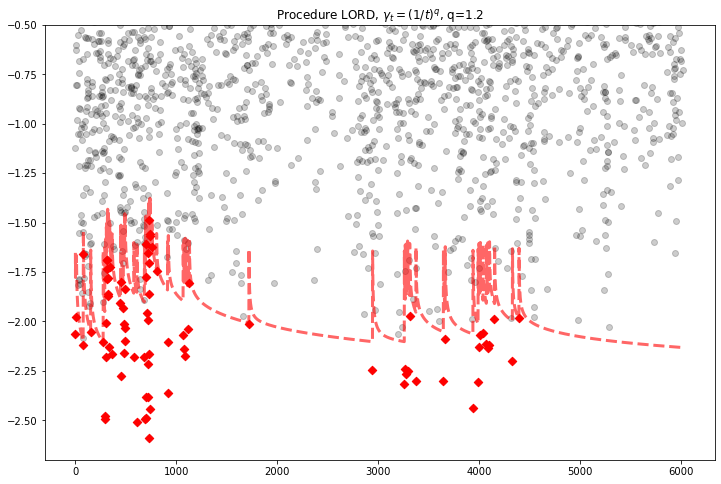

In [67]:
plt.figure(figsize = (12,8))
plt.scatter(np.arange(dataSain.shape[1]), -np.log(-np.log(pvals)), color='k', alpha=0.2)
plt.plot(np.arange(len(pvals)), -np.log(-np.log(Alpha_lordseq)), '--r', alpha=0.6, linewidth=3)
plt.scatter(R_lordseq, -np.log(-np.log(pvals[R_lordseq])), color='r', marker='D')
plt.ylim(-2.7,-0.5)
#plt.legend()
plt.title(fr'Procedure LORD, $\gamma_t = (1/t)^q$, q={q:.1f}');

### PROCEDURE LORD NON SEQUENTIELLE

In [38]:
def gamma_seq(q, N):
    res = np.array([1/(i+1)**q for i in range(N)])
    return(res/np.sum(res))

In [39]:
def LORD(alpha, pvals, W, seq_gamma):
    S = len(pvals)
    seq_alpha = W*seq_gamma
    tau = [] # memorize times t of rejections, 
    #clock = 0
    for t in np.arange(S-1):
        if pvals[t] <= seq_alpha[t]:
            #clock += 1
            tau.append(t)       
        if len(tau) == 1:
            t1 = t # tau1 memorized
            seq_alpha[t+1] += (alpha-W)*seq_gamma[t+1-t1]
        if len(tau) > 1: 
            seq_alpha[t+1] += -W*seq_gamma[t+1-t1] + np.sum(alpha*seq_gamma[t+1 - tau])          
    return(tau, seq_alpha) 

In [40]:
alpha = 0.05
W = alpha/2
q=1.2
seq_gamma = gamma_seq(q, len(pvals))
R_lord, Alpha_lord = LORD(alpha, pvals, W, seq_gamma)

In [41]:
performances_LORD(alpha, Alpha_lord, R_lord);

Tests Multiples en ligne - Contrôle du mFDR - Procédure LORD
Niveau du mFDR : 0.05
Nombre de détections : 0
Budget non dépensé : 0.025


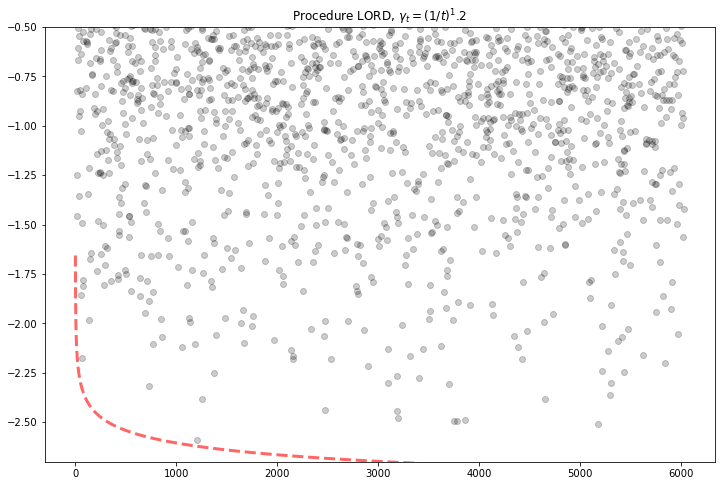

In [42]:
plt.figure(figsize = (12,8))
plt.scatter(np.arange(dataSain.shape[1]), -np.log(-np.log(pvals)), color='k', alpha=0.2)
plt.plot(np.arange(len(pvals)), -np.log(-np.log(Alpha_lord)), '--r', alpha=0.6, linewidth=3)
plt.scatter(R_lord, -np.log(-np.log(pvals[R_lord])), color='r', marker='D')
plt.ylim(-2.7,-0.5)
#plt.legend()
plt.title(fr'Procedure LORD, $\gamma_t = (1/t)^{q}$');

### PROCEDURE ALORD

In [55]:
#old
def ALORD(alpha, pvals, W, seq_gamma, llambda):
    S = len(pvals)
    Tau = np.zeros(len(pvals))
    Tau[pvals>=llambda] = 1
    Tau0 = 1 + np.asarray(Tau.cumsum(), dtype=int)
    R = []  
    seq_alpha = (1-llambda)*W*seq_gamma[Tau0]
    
    for t in range(S):
        if pvals[t] <= seq_alpha[t]:
            R.append(t)    
            if len(R) == 1:
                for m in np.arange(t+1, S):
                    seq_alpha[m] += (1-llambda)*(alpha-W)*seq_gamma[Tau0][m-t-1]
            if len(R) > 1:
                for m in np.arange(t+1, S):
                    seq_alpha[m] += (1-llambda)*alpha*seq_gamma[Tau0][m-t-1]
    return(R, seq_alpha)   

In [56]:
def performances_ALORD(alpha, llambda, Procedure, R):
    N_Detections = len(R)
    Depenses = np.sum(Procedure)
    Budget = alpha*max(1,N_Detections)
    Bilan = Budget-Depenses
    print("Tests Multiples en ligne - Contrôle du mFDR - Procédure ALORD")
    print(f"Niveau du mFDR : {alpha:.2}")
    print(f"Paramètre lambda : {llambda:.2f}")
    print(f"Nombre de détections : {N_Detections}")
    print(f"Budget non dépensé : {Bilan:.3f}")
    return(N_Detections, Budget, Depenses, Bilan) 

In [68]:
alpha = 0.1
W = alpha/1.2
q=1.2
llambda = alpha
seq_alpha=[]
R=[]
tau=[]
seq_gamma = gamma_seq(q,len(pvals))

R_alord, Alpha_alord = ALORD(alpha, pvals, W, seq_gamma, llambda)

In [69]:
performances_ALORD(alpha, llambda, Alpha_alord, R_alord);

Tests Multiples en ligne - Contrôle du mFDR - Procédure ALORD
Niveau du mFDR : 0.1
Paramètre lambda : 0.10
Nombre de détections : 93
Budget non dépensé : 0.695


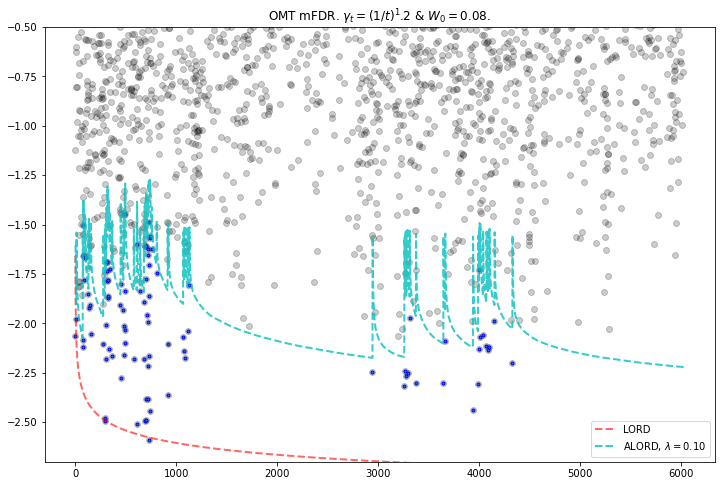

In [70]:
plt.figure(figsize = (12,8))
plt.scatter(np.arange(dataSain.shape[1]), -np.log(-np.log(pvals)), color='k', alpha=0.2)
plt.plot(np.arange(len(pvals)), -np.log(-np.log(Alpha_lord)), '--r', alpha=0.6, linewidth=2, label=fr'LORD')
plt.plot(np.arange(len(pvals)), -np.log(-np.log(Alpha_alord)), '--c', alpha=0.8, linewidth=2, label=fr'ALORD, $\lambda={llambda:.2f}$' )
plt.scatter(R_lord, -np.log(-np.log(pvals[R_lord])), color='r', marker='D')
plt.scatter(R_alord, -np.log(-np.log(pvals[R_alord])), edgecolor='b', marker='.')
plt.ylim(-2.7,-0.5)
plt.legend()
plt.title(fr'OMT mFDR. $\gamma_t = (1/t)^{q}$ & $W_0={W:.2f}$.');

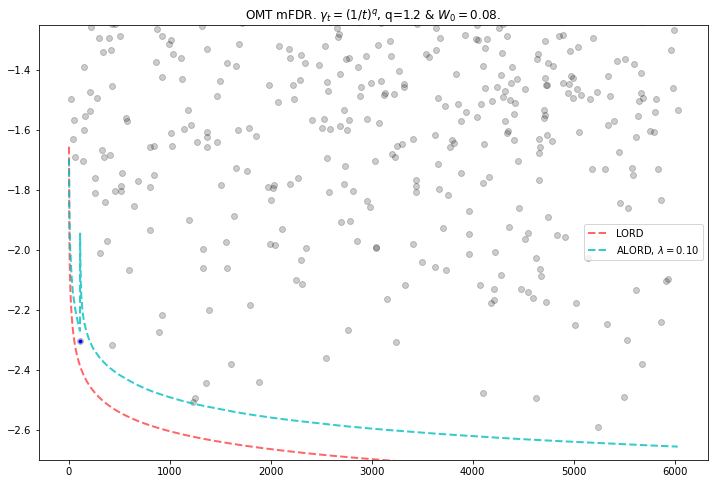

In [60]:
plt.figure(figsize = (12,8))
plt.scatter(np.arange(dataSain.shape[1]), -np.log(-np.log(pvals)), color='k', alpha=0.2)
plt.plot(np.arange(len(pvals)), -np.log(-np.log(Alpha_lord)), '--r', alpha=0.6, linewidth=2, label=fr'LORD')
plt.plot(np.arange(len(pvals)), -np.log(-np.log(Alpha_alord)), '--c', alpha=0.8, linewidth=2, label=fr'ALORD, $\lambda={llambda:.2f}$' )
plt.scatter(R_lord, -np.log(-np.log(pvals[R_lord])), color='r', marker='D')
plt.scatter(R_alord, -np.log(-np.log(pvals[R_alord])), color='b', marker='.')
plt.ylim(-2.7,-1.25)
plt.legend()
plt.title(fr'OMT mFDR. $\gamma_t=(1/t)^q$, q={q} & $W_0={W:.2f}$.');

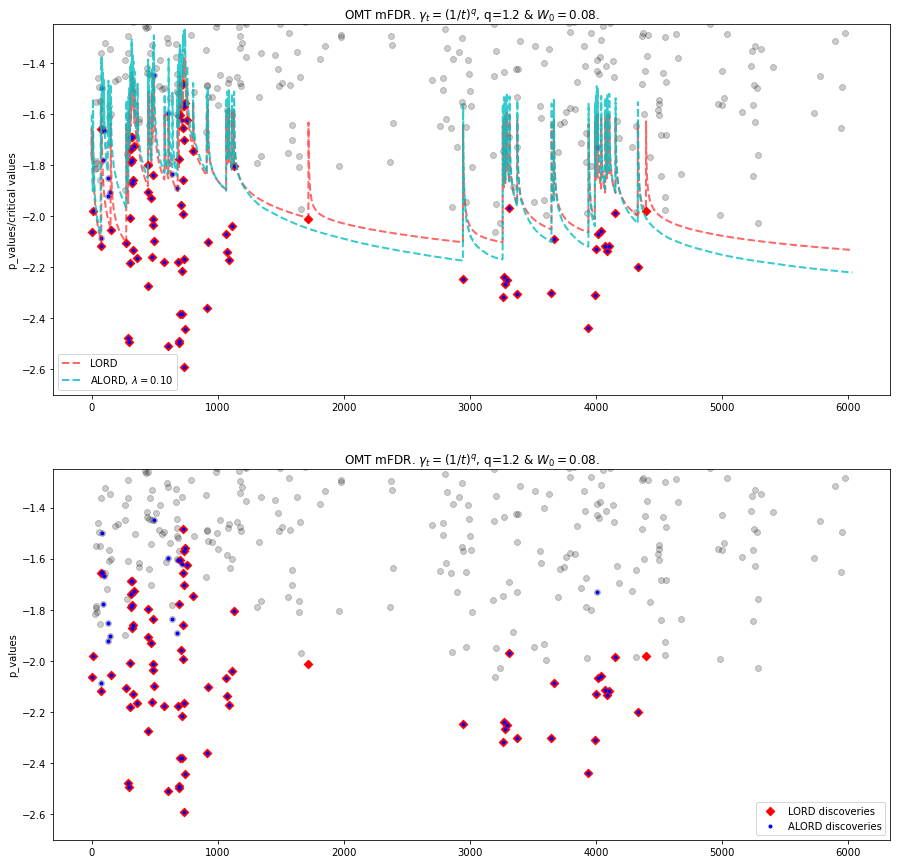

In [25]:
fig, ax = plt.subplots(2,1, sharex='row', figsize=(15,15))
ax[0].scatter(np.arange(dataSain.shape[1]), -np.log(-np.log(pvals)), color='k', alpha=0.2)
ax[0].plot(np.arange(len(pvals)), -np.log(-np.log(Alpha_lordseq)), '--r', alpha=0.6, linewidth=2, label=fr'LORD')
ax[0].plot(np.arange(len(pvals)), -np.log(-np.log(Alpha_alord)), '--c', alpha=0.8, linewidth=2, label=fr'ALORD, $\lambda={llambda:.2f}$' )
ax[0].scatter(R_lordseq, -np.log(-np.log(pvals[R_lordseq])), color='r', marker='D')
ax[0].scatter(R_alord, -np.log(-np.log(pvals[R_alord])), color='b', marker='.')
ax[0].set_ylim(-2.7,-1.25)
ax[0].set_ylabel('p_values/critical values')
ax[0].legend()
ax[0].set_title(fr'OMT mFDR. $\gamma_t=(1/t)^q$, q={q} & $W_0={W:.2f}$.');
ax[1].scatter(np.arange(dataSain.shape[1]), -np.log(-np.log(pvals)), color='k', alpha=0.2)
ax[1].scatter(R_lordseq, -np.log(-np.log(pvals[R_lordseq])), color='r', marker='D', label='LORD discoveries')
ax[1].scatter(R_alord, -np.log(-np.log(pvals[R_alord])), color='b', marker='.', label='ALORD discoveries')
ax[1].set_ylim(-2.7,-1.25)
ax[1].set_ylabel('p_values')
ax[1].legend()
ax[1].set_title(fr'OMT mFDR. $\gamma_t=(1/t)^q$, q={q} & $W_0={W:.2f}$.');
plt.savefig('LORD_ALORD.jpg')